<a href="https://colab.research.google.com/github/dcpatton/credit-card-fraud-detection/blob/master/credit_card_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import pandas as pd
import random
import warnings
warnings.filterwarnings("ignore")

print(tf.__version__)

seed = 51
tf.random.set_seed(seed)
random.seed(seed)

2.3.0


# Prep Data

In [2]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pip install kaggle --upgrade -q
!ls -l /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

-rw-r--r-- 1 root root 64 Aug 17 18:12 /root/.kaggle/kaggle.json


In [4]:
!kaggle datasets download mlg-ulb/creditcardfraud --unzip

 99% 65.0M/66.0M [00:00<00:00, 119MB/s] 
100% 66.0M/66.0M [00:00<00:00, 134MB/s]


In [5]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Assuming the features were scaled before PCA. What type of scaling was used?

**Also, this probably introduces leakage!**

In [6]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, stratify=df['Class'], test_size=0.2, random_state=seed)
train_df, val_df = train_test_split(train_df, stratify=train_df['Class'], test_size=0.2, random_state=seed)

In [8]:
y_train = train_df['Class'].values
y_val = val_df['Class'].values
y_test = test_df['Class'].values
x_train = train_df.drop(['Class'], axis='columns').values
x_val = val_df.drop(['Class'], axis='columns').values
x_test = test_df.drop(['Class'], axis='columns').values

In [9]:
from numpy import bincount
neg, pos = bincount(y_train)
total = neg + pos

In [10]:
def compute_metrics(y_true, y_pred):
  tp = tf.keras.metrics.TruePositives()
  tp.update_state(y_true, y_pred)
  tp = int(tp.result().numpy())
  fp = tf.keras.metrics.FalsePositives()
  fp.update_state(y_true, y_pred)
  fp = int(fp.result().numpy())
  tn = tf.keras.metrics.TrueNegatives()
  tn.update_state(y_true, y_pred)
  tn = int(tn.result().numpy())
  fn = tf.keras.metrics.FalseNegatives()
  fn.update_state(y_true, y_pred)
  fn = int(fn.result().numpy())
  return [tp, fn, fp, tn]

In [11]:
tp_df = pd.DataFrame()
fn_df = pd.DataFrame()
fp_df = pd.DataFrame()
tn_df = pd.DataFrame()

In [12]:
def print_metrics(metrics):
  print('Fraudulent Transactions Detected (True Positives): ' + str(metrics[0]))
  print('Fraudulent Transactions Missed (False Negatives): ' + str(metrics[1]))
  print('Legitimate Transactions Incorrectly Detected (False Positives): ' + str(metrics[2]))
  print('Legitimate Transactions Detected (True Negatives): ' + str(metrics[3]))

# Baseline

In [13]:
%%time
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=seed)
classifier.fit(x_train, y_train)

CPU times: user 3min, sys: 135 ms, total: 3min
Wall time: 1min 32s


In [14]:
y_pred = classifier.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
RF_AUPRC = auprc.result().numpy()
RF_AUPRC

0.70950973

In [15]:
RF_metrics = compute_metrics(y_test, y_pred)
print_metrics(RF_metrics)

Fraudulent Transactions Detected (True Positives): 74
Fraudulent Transactions Missed (False Negatives): 24
Legitimate Transactions Incorrectly Detected (False Positives): 5
Legitimate Transactions Detected (True Negatives): 56859


In [16]:
%%time
from xgboost import XGBClassifier

xgbc = XGBClassifier(objective='binary:logistic', seed=seed)
xgbc.fit(x_train, y_train)

CPU times: user 36.4 s, sys: 128 ms, total: 36.5 s
Wall time: 37.2 s


In [17]:
y_pred = xgbc.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
XGB_AUPRC = auprc.result().numpy()
XGB_AUPRC

0.6574006

In [18]:
XGB_metrics = compute_metrics(y_test, y_pred)
print_metrics(XGB_metrics)

Fraudulent Transactions Detected (True Positives): 73
Fraudulent Transactions Missed (False Negatives): 25
Legitimate Transactions Incorrectly Detected (False Positives): 10
Legitimate Transactions Detected (True Negatives): 56854


In [19]:
from tensorflow.keras.layers import Dense, Input, ELU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

def create_model():
  tf.keras.backend.clear_session()
  input1 = Input(shape=(x_train.shape[1],), name='input1')
  x = Dense(96)(input1)
  x = BatchNormalization()(x)
  x = ELU()(x)
  x = Dropout(0.33)(x)
  x = Dense(96)(x)
  x = BatchNormalization()(x)
  x = ELU()(x)
  x = Dropout(0.33)(x)
  x = Dense(96)(x)
  x = BatchNormalization()(x)
  x = ELU()(x)
  x = Dropout(0.33)(x)
  out = Dense(1, activation='sigmoid', name='out')(x)

  _model = Model(inputs=[input1], outputs=[out])
  _model.summary()

  _model.compile(optimizer=Adam(), loss='binary_crossentropy', 
                 metrics=[tf.keras.metrics.AUC(curve='ROC', name='auroc'), 
                          tf.keras.metrics.AUC(curve='PR', name='auprc')])
  return _model

model = create_model()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 96)                2976      
_________________________________________________________________
batch_normalization (BatchNo (None, 96)                384       
_________________________________________________________________
elu (ELU)                    (None, 96)                0         
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96)               

In [20]:
BATCH_SIZE=256

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_filepath = 'model.h5'
mc = ModelCheckpoint(checkpoint_filepath, verbose=0, save_weights_only=True, 
                     monitor='val_auprc', mode='max', save_best_only=True)

es = EarlyStopping(monitor='val_auprc', patience=10, verbose=1, mode='max')

history = model.fit(x_train, y_train, epochs=200, verbose=2, callbacks=[es, mc], 
                    validation_data=(x_val, y_val), batch_size=BATCH_SIZE)

Epoch 1/200
713/713 - 4s - loss: 0.0803 - auroc: 0.7907 - auprc: 0.1876 - val_loss: 0.0058 - val_auroc: 0.9484 - val_auprc: 0.7504
Epoch 2/200
713/713 - 4s - loss: 0.0080 - auroc: 0.8885 - auprc: 0.5591 - val_loss: 0.0046 - val_auroc: 0.9366 - val_auprc: 0.7588
Epoch 3/200
713/713 - 4s - loss: 0.0058 - auroc: 0.9190 - auprc: 0.6390 - val_loss: 0.0038 - val_auroc: 0.9429 - val_auprc: 0.7713
Epoch 4/200
713/713 - 4s - loss: 0.0049 - auroc: 0.9194 - auprc: 0.6826 - val_loss: 0.0037 - val_auroc: 0.9429 - val_auprc: 0.7773
Epoch 5/200
713/713 - 4s - loss: 0.0048 - auroc: 0.9138 - auprc: 0.6952 - val_loss: 0.0036 - val_auroc: 0.9490 - val_auprc: 0.7866
Epoch 6/200
713/713 - 4s - loss: 0.0042 - auroc: 0.9284 - auprc: 0.6869 - val_loss: 0.0030 - val_auroc: 0.9366 - val_auprc: 0.8122
Epoch 7/200
713/713 - 4s - loss: 0.0039 - auroc: 0.9319 - auprc: 0.7399 - val_loss: 0.0027 - val_auroc: 0.9428 - val_auprc: 0.8166
Epoch 8/200
713/713 - 4s - loss: 0.0038 - auroc: 0.9336 - auprc: 0.7519 - val_loss:

In [22]:
model.load_weights(checkpoint_filepath)
model.evaluate(x_test, y_test)

1781/1781 [==============================] - 5s 3ms/step - loss: 0.0037 - auroc: 0.9331 - auprc: 0.8223


[0.003725312417373061, 0.9330689311027527, 0.8223409056663513]

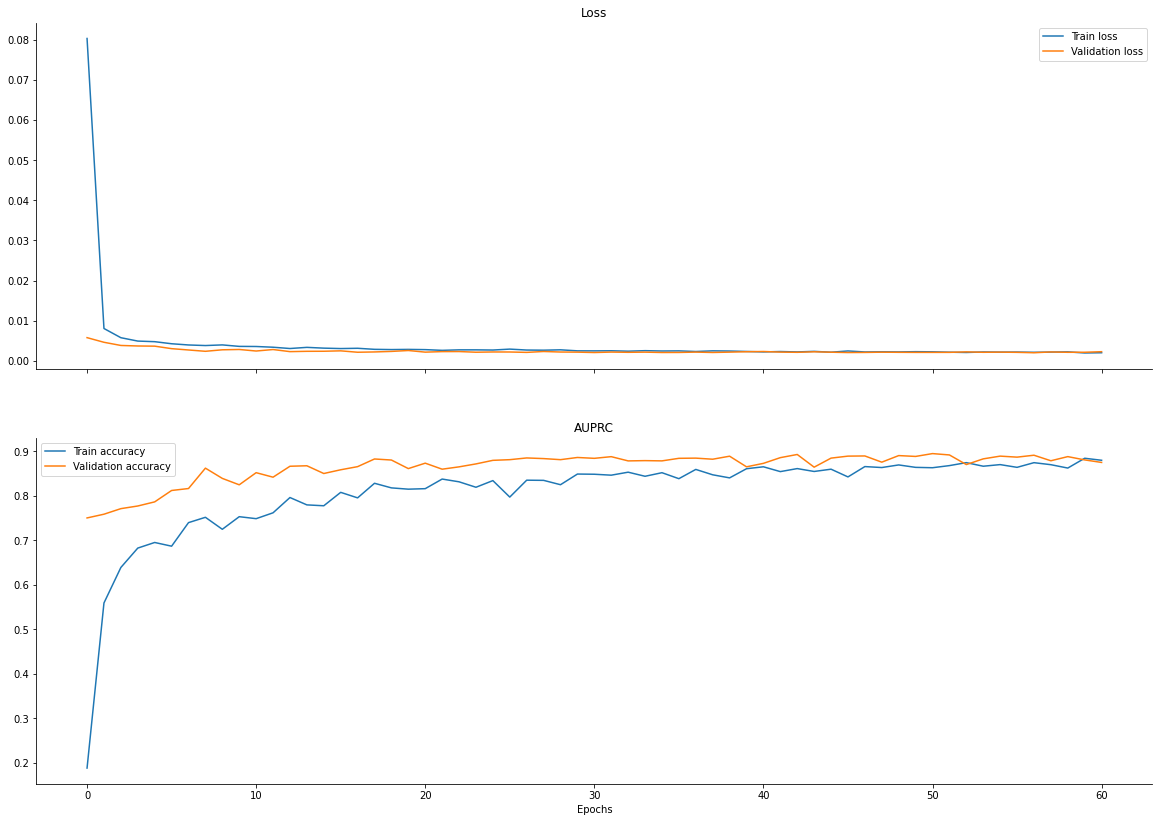

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['auprc'], label='Train accuracy')
ax2.plot(history['val_auprc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('AUPRC')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [24]:
y_pred = model.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
TF_Model_AUPRC = auprc.result().numpy()
TF_Model_AUPRC

0.8223409

In [25]:
TF_Model_metrics = compute_metrics(y_test, y_pred)
print_metrics(TF_Model_metrics)

Fraudulent Transactions Detected (True Positives): 77
Fraudulent Transactions Missed (False Negatives): 21
Legitimate Transactions Incorrectly Detected (False Positives): 9
Legitimate Transactions Detected (True Negatives): 56855


In [26]:
print('Random Forest ********************')
print_metrics(RF_metrics)
print('XGBoost **************************')
print_metrics(XGB_metrics)
print('TensorFlow DNN Model *************')
print_metrics(TF_Model_metrics)

Random Forest ********************
Fraudulent Transactions Detected (True Positives): 74
Fraudulent Transactions Missed (False Negatives): 24
Legitimate Transactions Incorrectly Detected (False Positives): 5
Legitimate Transactions Detected (True Negatives): 56859
XGBoost **************************
Fraudulent Transactions Detected (True Positives): 73
Fraudulent Transactions Missed (False Negatives): 25
Legitimate Transactions Incorrectly Detected (False Positives): 10
Legitimate Transactions Detected (True Negatives): 56854
TensorFlow DNN Model *************
Fraudulent Transactions Detected (True Positives): 77
Fraudulent Transactions Missed (False Negatives): 21
Legitimate Transactions Incorrectly Detected (False Positives): 9
Legitimate Transactions Detected (True Negatives): 56855


In [27]:
models = ['RandomForest', 'XGBoost', 'TensorFlow DNN']
tp_df['Model'] = models
results = [RF_metrics[0], XGB_metrics[0], TF_Model_metrics[0]]
tp_df['baseline'] = results
fn_df['Model'] = models
results = [RF_metrics[1], XGB_metrics[1], TF_Model_metrics[1]]
fn_df['baseline'] = results
fp_df['Model'] = models
results = [RF_metrics[2], XGB_metrics[2], TF_Model_metrics[2]]
fp_df['baseline'] = results
tn_df['Model'] = models
results = [RF_metrics[3], XGB_metrics[3], TF_Model_metrics[3]]
tn_df['baseline'] = results

In [28]:
auprc_df = pd.DataFrame()
results = [RF_AUPRC, XGB_AUPRC, TF_Model_AUPRC]
auprc_df['Model'] = models
auprc_df['baseline'] = results

# Class Weighting
Try to improve this by having our loss function focus more on the minority class. We will do this with class weights during model fitting.

In [29]:
# The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as 
# n_samples / (n_classes * np.bincount(y))

# The “balanced_subsample” mode is the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown.

classifier = RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=seed)
classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=51, verbose=0,
                       warm_start=False)

In [30]:
y_pred = classifier.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
RF_AUPRC = auprc.result().numpy()
RF_AUPRC

0.6983687

In [31]:
RF_metrics = compute_metrics(y_test, y_pred)
print_metrics(RF_metrics)

Fraudulent Transactions Detected (True Positives): 72
Fraudulent Transactions Missed (False Negatives): 26
Legitimate Transactions Incorrectly Detected (False Positives): 4
Legitimate Transactions Detected (True Negatives): 56860


In [32]:
from math import sqrt
scale_pos_weight = sqrt(neg/pos) 

xgbc = XGBClassifier(objective='binary:logistic', seed=seed,
                     scale_pos_weight=scale_pos_weight)
xgbc.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=24.034432971342767,
              seed=51, silent=None, subsample=1, verbosity=1)

In [33]:
y_pred = xgbc.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
XGB_AUPRC = auprc.result().numpy()
XGB_AUPRC

0.62893724

In [34]:
XGB_metrics = compute_metrics(y_test, y_pred)
print_metrics(XGB_metrics)

Fraudulent Transactions Detected (True Positives): 78
Fraudulent Transactions Missed (False Negatives): 20
Legitimate Transactions Incorrectly Detected (False Positives): 21
Legitimate Transactions Detected (True Negatives): 56843


In [35]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

class_weight = {0: weight_for_0, 1: weight_for_1}

model = create_model()

Weight for class 0: 0.50
Weight for class 1: 289.33
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 96)                2976      
_________________________________________________________________
batch_normalization (BatchNo (None, 96)                384       
_________________________________________________________________
elu (ELU)                    (None, 96)                0         
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
ba

In [36]:
checkpoint_filepath = 'model.h5'
mc = ModelCheckpoint(checkpoint_filepath, verbose=0, save_weights_only=True, 
                     monitor='val_auprc', mode='max', save_best_only=True)

es = EarlyStopping(monitor='val_auprc', patience=30, verbose=1, mode='max')

history = model.fit(x_train, y_train, epochs=200, verbose=2, callbacks=[es, mc], 
                    validation_data=(x_val, y_val), class_weight=class_weight, 
                    batch_size=BATCH_SIZE)

Epoch 1/200
713/713 - 4s - loss: 0.3090 - auroc: 0.9404 - auprc: 0.2735 - val_loss: 0.2275 - val_auroc: 0.9937 - val_auprc: 0.2849
Epoch 2/200
713/713 - 4s - loss: 0.2217 - auroc: 0.9666 - auprc: 0.2863 - val_loss: 0.1264 - val_auroc: 0.9717 - val_auprc: 0.7334
Epoch 3/200
713/713 - 4s - loss: 0.1972 - auroc: 0.9692 - auprc: 0.4878 - val_loss: 0.1169 - val_auroc: 0.9904 - val_auprc: 0.7528
Epoch 4/200
713/713 - 4s - loss: 0.1936 - auroc: 0.9714 - auprc: 0.5717 - val_loss: 0.1293 - val_auroc: 0.9927 - val_auprc: 0.7574
Epoch 5/200
713/713 - 4s - loss: 0.1549 - auroc: 0.9832 - auprc: 0.6072 - val_loss: 0.1186 - val_auroc: 0.9922 - val_auprc: 0.7761
Epoch 6/200
713/713 - 4s - loss: 0.1674 - auroc: 0.9809 - auprc: 0.5360 - val_loss: 0.0750 - val_auroc: 0.9831 - val_auprc: 0.7824
Epoch 7/200
713/713 - 4s - loss: 0.1403 - auroc: 0.9869 - auprc: 0.6176 - val_loss: 0.1162 - val_auroc: 0.9908 - val_auprc: 0.7590
Epoch 8/200
713/713 - 4s - loss: 0.1372 - auroc: 0.9876 - auprc: 0.5773 - val_loss:

In [37]:
model.load_weights(checkpoint_filepath)
model.evaluate(x_test, y_test)

1781/1781 [==============================] - 5s 3ms/step - loss: 0.0697 - auroc: 0.9571 - auprc: 0.7124


[0.06974510103464127, 0.957082211971283, 0.712368369102478]

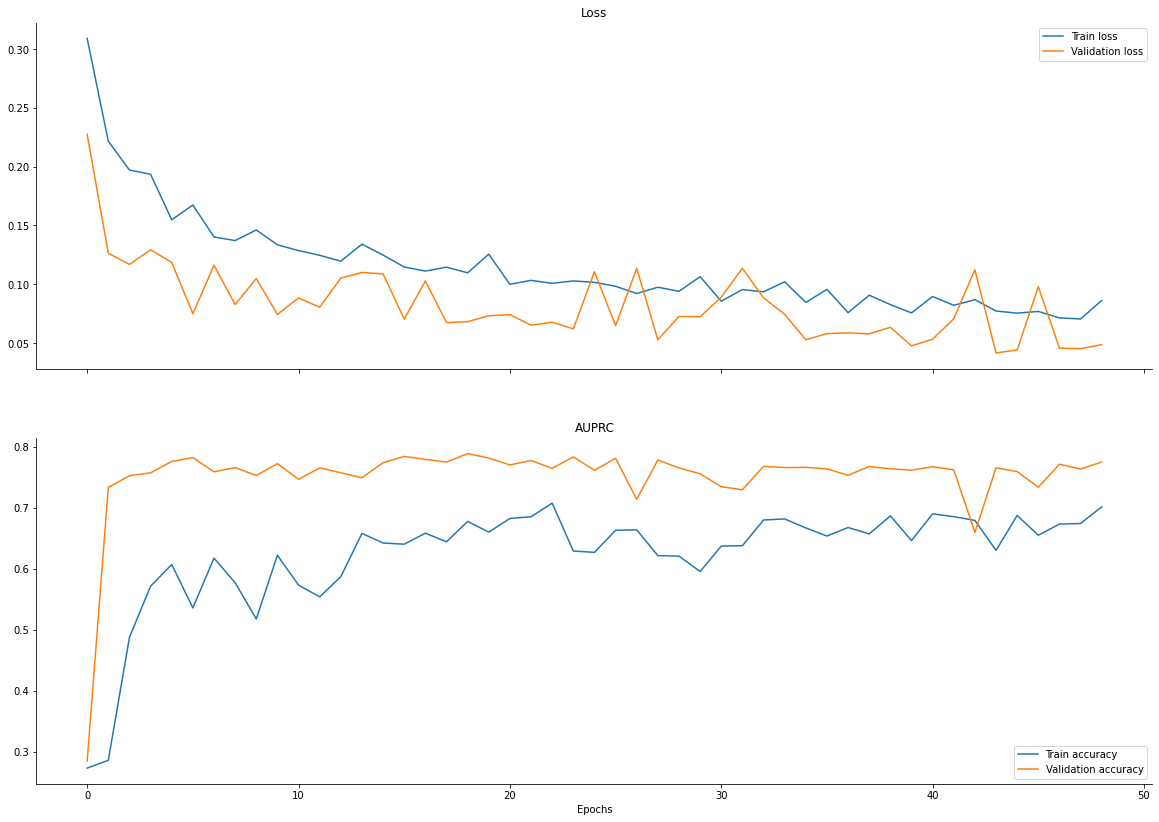

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['auprc'], label='Train accuracy')
ax2.plot(history['val_auprc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('AUPRC')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [39]:
y_pred = model.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
TF_Model_AUPRC = auprc.result().numpy()
TF_Model_AUPRC

0.71236837

In [40]:
TF_Model_metrics = compute_metrics(y_test, y_pred)
print_metrics(TF_Model_metrics)

Fraudulent Transactions Detected (True Positives): 86
Fraudulent Transactions Missed (False Negatives): 12
Legitimate Transactions Incorrectly Detected (False Positives): 1265
Legitimate Transactions Detected (True Negatives): 55599


In [41]:
print('RF_AUPRC: ' + str(RF_AUPRC))
print('XGB_AUPRC: ' + str(XGB_AUPRC))
print('TF_Model_AUPRC: ' + str(TF_Model_AUPRC))

RF_AUPRC: 0.6983687
XGB_AUPRC: 0.62893724
TF_Model_AUPRC: 0.71236837


In [42]:
print('Random Forest ********************')
print_metrics(RF_metrics)
print('XGBoost **************************')
print_metrics(XGB_metrics)
print('TensorFlow DNN Model ************')
print_metrics(TF_Model_metrics)


Random Forest ********************
Fraudulent Transactions Detected (True Positives): 72
Fraudulent Transactions Missed (False Negatives): 26
Legitimate Transactions Incorrectly Detected (False Positives): 4
Legitimate Transactions Detected (True Negatives): 56860
XGBoost **************************
Fraudulent Transactions Detected (True Positives): 78
Fraudulent Transactions Missed (False Negatives): 20
Legitimate Transactions Incorrectly Detected (False Positives): 21
Legitimate Transactions Detected (True Negatives): 56843
TensorFlow DNN Model ************
Fraudulent Transactions Detected (True Positives): 86
Fraudulent Transactions Missed (False Negatives): 12
Legitimate Transactions Incorrectly Detected (False Positives): 1265
Legitimate Transactions Detected (True Negatives): 55599


So we are improving on Recall, but worse on Precision



In [43]:
tp_df['Model'] = models
results = [RF_metrics[0], XGB_metrics[0], TF_Model_metrics[0]]
tp_df['class weighted'] = results
fn_df['Model'] = models
results = [RF_metrics[1], XGB_metrics[1], TF_Model_metrics[1]]
fn_df['class weighted'] = results
fp_df['Model'] = models
results = [RF_metrics[2], XGB_metrics[2], TF_Model_metrics[2]]
fp_df['class weighted'] = results
tn_df['Model'] = models
results = [RF_metrics[3], XGB_metrics[3], TF_Model_metrics[3]]
tn_df['class weighted'] = results

In [44]:
results = [RF_AUPRC, XGB_AUPRC, TF_Model_AUPRC]
auprc_df['class weighted'] = results

# Undersampling (Random)

In [45]:
y_train = train_df['Class'].values
x_train = train_df.drop(['Class'], axis='columns')
x_train = x_train.values

from numpy import bincount
neg, pos = bincount(y_train)
print('Original balance: ' + str(neg) + ' non-fraud, ' + str(pos) + ' fraud')

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=seed)
x_train, y_train = rus.fit_resample(x_train, y_train)

neg, pos = bincount(y_train)
print('New balance: ' + str(neg) + ' non-fraud, ' + str(pos) + ' fraud')

Original balance: 181961 non-fraud, 315 fraud
New balance: 315 non-fraud, 315 fraud


In [46]:
classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=seed)
classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=51, verbose=0,
                       warm_start=False)

In [47]:
columns = train_df.columns.to_list()
columns.remove('Class')
print("The Features Importance are: ")  
for feature, value in zip(columns, classifier.feature_importances_):
        print(feature, value)

The Features Importance are: 
V1 0.010242805437496571
V2 0.029972801456962
V3 0.0488391169759337
V4 0.0697577595806733
V5 0.010669791130335752
V6 0.01220296211897637
V7 0.0398848692439779
V8 0.010964789762678328
V9 0.011211050369447017
V10 0.12226522588489386
V11 0.09766139591859441
V12 0.10028689562279718
V13 0.008382218163270162
V14 0.18196254904360698
V15 0.010662022815996108
V16 0.06967422143627304
V17 0.061742989941040674
V18 0.01006538695986429
V19 0.00946532836177493
V20 0.010444993408954233
V21 0.01477344650522887
V22 0.005686859926775454
V23 0.006265633198594381
V24 0.006249596112205176
V25 0.004172839013130712
V26 0.004793648120522799
V27 0.00802949297658804
V28 0.008128716095879548
scaled_amount 0.010452160141903914
scaled_time 0.005088434275624461


In [48]:
y_pred = classifier.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
RF_AUPRC = auprc.result().numpy()
RF_AUPRC

0.047769353

In [49]:
RF_metrics = compute_metrics(y_test, y_pred)
print_metrics(RF_metrics)

Fraudulent Transactions Detected (True Positives): 87
Fraudulent Transactions Missed (False Negatives): 11
Legitimate Transactions Incorrectly Detected (False Positives): 1552
Legitimate Transactions Detected (True Negatives): 55312


In [50]:
xgbc = XGBClassifier(objective='binary:logistic', seed=seed)
xgbc.fit(x_train, y_train, eval_metric='aucpr')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=51,
              silent=None, subsample=1, verbosity=1)

In [51]:
y_pred = xgbc.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
XGB_AUPRC = auprc.result().numpy()
XGB_AUPRC

0.04445454

In [52]:
XGB_metrics = compute_metrics(y_test, y_pred)
print_metrics(XGB_metrics)

Fraudulent Transactions Detected (True Positives): 88
Fraudulent Transactions Missed (False Negatives): 10
Legitimate Transactions Incorrectly Detected (False Positives): 1713
Legitimate Transactions Detected (True Negatives): 55151


In [53]:
model = create_model()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 96)                2976      
_________________________________________________________________
batch_normalization (BatchNo (None, 96)                384       
_________________________________________________________________
elu (ELU)                    (None, 96)                0         
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96)               

In [54]:
checkpoint_filepath = 'model.h5'
mc = ModelCheckpoint(checkpoint_filepath, verbose=0, save_weights_only=True, 
                     monitor='val_auprc', mode='max', save_best_only=True)

es = EarlyStopping(monitor='val_auprc', patience=30, verbose=1, mode='max')
history = model.fit(x_train, y_train, epochs=200, verbose=2, callbacks=[es, mc], 
                    validation_data=(x_val, y_val), batch_size=8)

Epoch 1/200
79/79 - 15s - loss: 0.4373 - auroc: 0.8868 - auprc: 0.9017 - val_loss: 0.1750 - val_auroc: 0.9890 - val_auprc: 0.5312
Epoch 2/200
79/79 - 15s - loss: 0.3760 - auroc: 0.9125 - auprc: 0.9271 - val_loss: 0.0844 - val_auroc: 0.9909 - val_auprc: 0.6103
Epoch 3/200
79/79 - 15s - loss: 0.3065 - auroc: 0.9365 - auprc: 0.9512 - val_loss: 0.0722 - val_auroc: 0.9903 - val_auprc: 0.5924
Epoch 4/200
79/79 - 15s - loss: 0.2845 - auroc: 0.9435 - auprc: 0.9573 - val_loss: 0.0668 - val_auroc: 0.9904 - val_auprc: 0.6221
Epoch 5/200
79/79 - 15s - loss: 0.2926 - auroc: 0.9411 - auprc: 0.9569 - val_loss: 0.0592 - val_auroc: 0.9909 - val_auprc: 0.6812
Epoch 6/200
79/79 - 15s - loss: 0.2862 - auroc: 0.9452 - auprc: 0.9585 - val_loss: 0.0719 - val_auroc: 0.9908 - val_auprc: 0.7257
Epoch 7/200
79/79 - 15s - loss: 0.2803 - auroc: 0.9460 - auprc: 0.9607 - val_loss: 0.0491 - val_auroc: 0.9909 - val_auprc: 0.7108
Epoch 8/200
79/79 - 15s - loss: 0.2652 - auroc: 0.9536 - auprc: 0.9589 - val_loss: 0.0662 

In [55]:
model.load_weights(checkpoint_filepath)
model.evaluate(x_test, y_test)

1781/1781 [==============================] - 5s 3ms/step - loss: 0.0925 - auroc: 0.9689 - auprc: 0.7342


[0.09253675490617752, 0.9689362049102783, 0.7342178225517273]

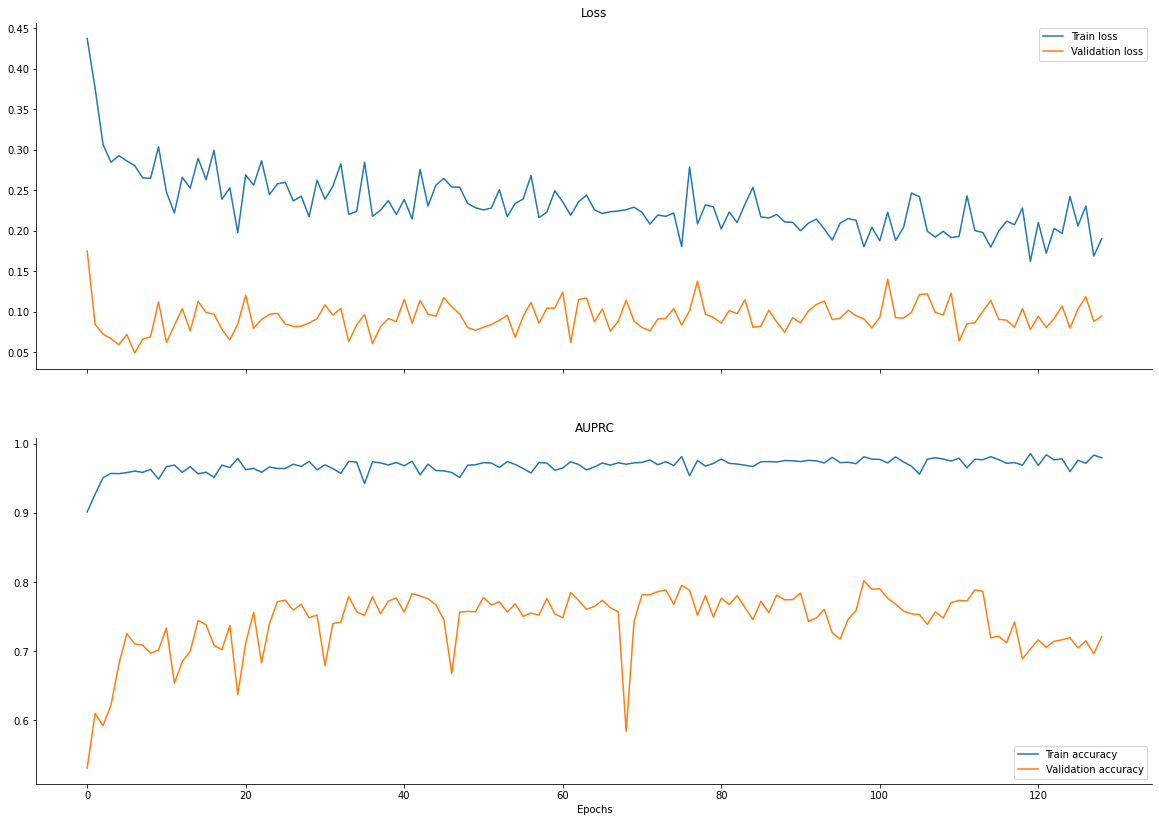

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['auprc'], label='Train accuracy')
ax2.plot(history['val_auprc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('AUPRC')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [57]:
y_pred = model.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
TF_Model_AUPRC = auprc.result().numpy()
TF_Model_AUPRC

0.7342178

In [58]:
TF_Model_metrics = compute_metrics(y_test, y_pred)
print_metrics(TF_Model_metrics)

Fraudulent Transactions Detected (True Positives): 90
Fraudulent Transactions Missed (False Negatives): 8
Legitimate Transactions Incorrectly Detected (False Positives): 1241
Legitimate Transactions Detected (True Negatives): 55623


In [59]:
print('RF_AUPRC: ' + str(RF_AUPRC))
print('XGB_AUPRC: ' + str(XGB_AUPRC))
print('TF_Model_AUPRC: ' + str(TF_Model_AUPRC))

RF_AUPRC: 0.047769353
XGB_AUPRC: 0.04445454
TF_Model_AUPRC: 0.7342178


In [60]:
print('Random Forest ********************')
print_metrics(RF_metrics)
print('XGBoost **************************')
print_metrics(XGB_metrics)
print('TensorFlow DNN Model1 ************')
print_metrics(TF_Model_metrics)

Random Forest ********************
Fraudulent Transactions Detected (True Positives): 87
Fraudulent Transactions Missed (False Negatives): 11
Legitimate Transactions Incorrectly Detected (False Positives): 1552
Legitimate Transactions Detected (True Negatives): 55312
XGBoost **************************
Fraudulent Transactions Detected (True Positives): 88
Fraudulent Transactions Missed (False Negatives): 10
Legitimate Transactions Incorrectly Detected (False Positives): 1713
Legitimate Transactions Detected (True Negatives): 55151
TensorFlow DNN Model1 ************
Fraudulent Transactions Detected (True Positives): 90
Fraudulent Transactions Missed (False Negatives): 8
Legitimate Transactions Incorrectly Detected (False Positives): 1241
Legitimate Transactions Detected (True Negatives): 55623


In [61]:
tp_df['Model'] = models
results = [RF_metrics[0], XGB_metrics[0], TF_Model_metrics[0]]
tp_df['Undersampling (Random)'] = results
fn_df['Model'] = models
results = [RF_metrics[1], XGB_metrics[1], TF_Model_metrics[1]]
fn_df['Undersampling (Random)'] = results
fp_df['Model'] = models
results = [RF_metrics[2], XGB_metrics[2], TF_Model_metrics[2]]
fp_df['Undersampling (Random)'] = results
tn_df['Model'] = models
results = [RF_metrics[3], XGB_metrics[3], TF_Model_metrics[3]]
tn_df['Undersampling (Random)'] = results

In [62]:
results = [RF_AUPRC, XGB_AUPRC, TF_Model_AUPRC]
auprc_df['Undersampling (Random)'] = results

# Undersampling (NearMiss)

In [63]:
y_train = train_df['Class'].values
x_train = train_df.drop(['Class'], axis='columns')
x_train = x_train.values

from numpy import bincount
neg, pos = bincount(y_train)
print('Original balance: ' + str(neg) + ' non-fraud, ' + str(pos) + ' fraud')

from imblearn.under_sampling import NearMiss
nm1 = NearMiss(version=1)
x_train, y_train = nm1.fit_resample(x_train, y_train)

neg, pos = bincount(y_train)
print('New balance: ' + str(neg) + ' non-fraud, ' + str(pos) + ' fraud')

Original balance: 181961 non-fraud, 315 fraud
New balance: 315 non-fraud, 315 fraud


In [64]:
# fraud_df = train_df.loc[df['Class'] == 1]
# non_fraud_df = train_df.loc[df['Class'] == 0][:len(fraud_df)]

# balanced_df = pd.concat([fraud_df, non_fraud_df])

# # Shuffle
# balanced_df = balanced_df.sample(frac=1, random_state=seed).reset_index(drop=True)

# balanced_df.head()

In [65]:
# y_train = balanced_df['Class'].values
# x_train = balanced_df.drop(['Class'], axis='columns')
# x_train = x_train.values

In [66]:
classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=seed)
classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=51, verbose=0,
                       warm_start=False)

In [67]:
y_pred = classifier.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
RF_AUPRC = auprc.result().numpy()
RF_AUPRC

0.0021636141

In [68]:
RF_metrics = compute_metrics(y_test, y_pred)
print_metrics(RF_metrics)

Fraudulent Transactions Detected (True Positives): 94
Fraudulent Transactions Missed (False Negatives): 4
Legitimate Transactions Incorrectly Detected (False Positives): 43150
Legitimate Transactions Detected (True Negatives): 13714


In [69]:
xgbc = XGBClassifier(objective='binary:logistic', seed=seed)
xgbc.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=51,
              silent=None, subsample=1, verbosity=1)

In [70]:
y_pred = xgbc.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
XGB_AUPRC = auprc.result().numpy()
XGB_AUPRC

0.0025975434

In [71]:
XGB_metrics = compute_metrics(y_test, y_pred)
print_metrics(XGB_metrics)

Fraudulent Transactions Detected (True Positives): 94
Fraudulent Transactions Missed (False Negatives): 4
Legitimate Transactions Incorrectly Detected (False Positives): 35802
Legitimate Transactions Detected (True Negatives): 21062


In [72]:
model = create_model()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 96)                2976      
_________________________________________________________________
batch_normalization (BatchNo (None, 96)                384       
_________________________________________________________________
elu (ELU)                    (None, 96)                0         
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96)               

In [73]:
checkpoint_filepath = 'model.h5'
mc = ModelCheckpoint(checkpoint_filepath, verbose=0, save_weights_only=True, 
                     monitor='val_auprc', mode='max', save_best_only=True)

es = EarlyStopping(monitor='val_auprc', patience=30, verbose=1, mode='max')
history = model.fit(x_train, y_train, epochs=200, verbose=2, callbacks=[es, mc], 
                    validation_data=(x_val, y_val), batch_size=8)

Epoch 1/200
79/79 - 15s - loss: 0.4004 - auroc: 0.8988 - auprc: 0.9152 - val_loss: 0.2413 - val_auroc: 0.9843 - val_auprc: 0.2116
Epoch 2/200
79/79 - 15s - loss: 0.3426 - auroc: 0.9204 - auprc: 0.9409 - val_loss: 0.1739 - val_auroc: 0.9809 - val_auprc: 0.1512
Epoch 3/200
79/79 - 15s - loss: 0.3174 - auroc: 0.9317 - auprc: 0.9498 - val_loss: 0.1408 - val_auroc: 0.9784 - val_auprc: 0.2143
Epoch 4/200
79/79 - 15s - loss: 0.3028 - auroc: 0.9341 - auprc: 0.9540 - val_loss: 0.1999 - val_auroc: 0.9760 - val_auprc: 0.0848
Epoch 5/200
79/79 - 16s - loss: 0.2616 - auroc: 0.9486 - auprc: 0.9629 - val_loss: 0.1547 - val_auroc: 0.9775 - val_auprc: 0.1387
Epoch 6/200
79/79 - 15s - loss: 0.2752 - auroc: 0.9465 - auprc: 0.9586 - val_loss: 0.3220 - val_auroc: 0.9627 - val_auprc: 0.0651
Epoch 7/200
79/79 - 15s - loss: 0.2456 - auroc: 0.9577 - auprc: 0.9666 - val_loss: 0.1772 - val_auroc: 0.9774 - val_auprc: 0.1424
Epoch 8/200
79/79 - 15s - loss: 0.2691 - auroc: 0.9478 - auprc: 0.9556 - val_loss: 0.3124 

In [74]:
model.load_weights(checkpoint_filepath)
model.evaluate(x_test, y_test)

1781/1781 [==============================] - 5s 3ms/step - loss: 0.1414 - auroc: 0.9569 - auprc: 0.2012


[0.14139653742313385, 0.956933856010437, 0.20121556520462036]

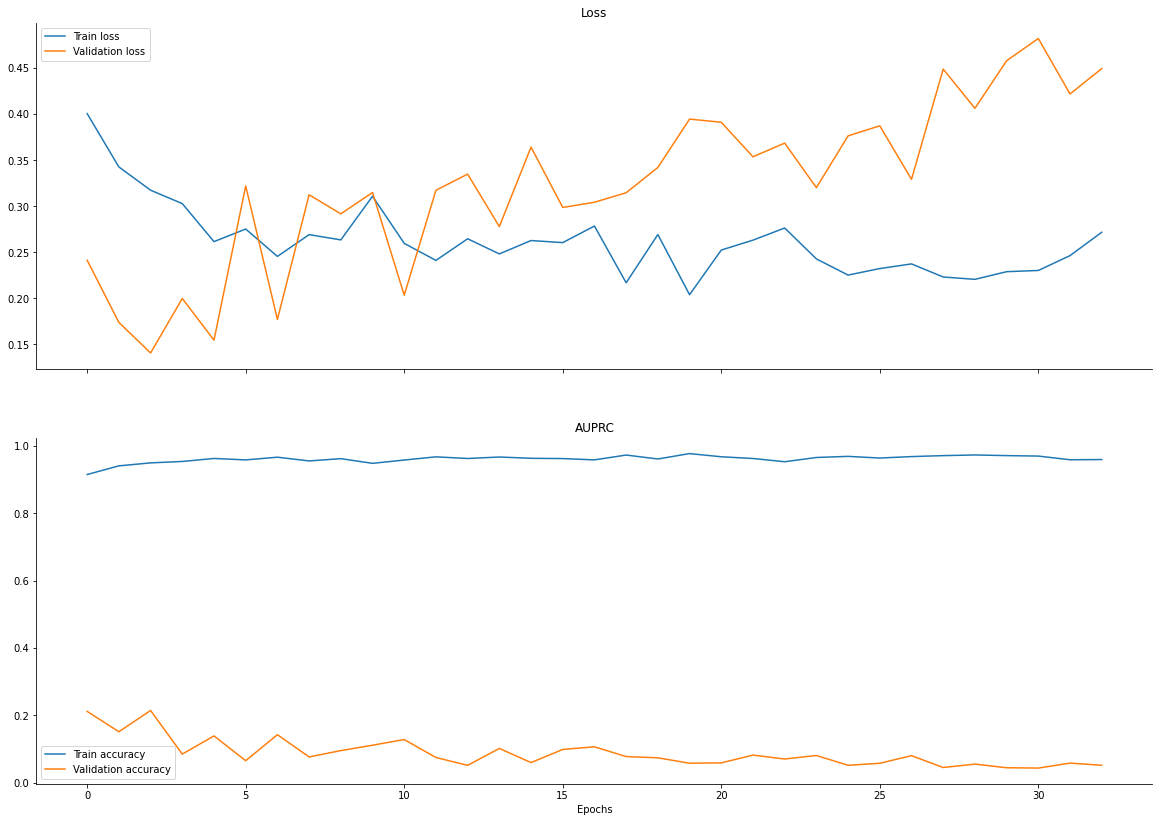

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['auprc'], label='Train accuracy')
ax2.plot(history['val_auprc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('AUPRC')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [76]:
y_pred = model.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
TF_Model_AUPRC = auprc.result().numpy()
TF_Model_AUPRC

0.20121557

In [77]:
TF_Model_metrics = compute_metrics(y_test, y_pred)
print_metrics(TF_Model_metrics)

Fraudulent Transactions Detected (True Positives): 80
Fraudulent Transactions Missed (False Negatives): 18
Legitimate Transactions Incorrectly Detected (False Positives): 1703
Legitimate Transactions Detected (True Negatives): 55161


In [78]:
print('RF_AUPRC: ' + str(RF_AUPRC))
print('XGB_AUPRC: ' + str(XGB_AUPRC))
print('TF_Model_AUPRC: ' + str(TF_Model_AUPRC))

RF_AUPRC: 0.0021636141
XGB_AUPRC: 0.0025975434
TF_Model_AUPRC: 0.20121557


In [79]:
print('Random Forest ********************')
print_metrics(RF_metrics)
print('XGBoost **************************')
print_metrics(XGB_metrics)
print('TensorFlow DNN Model1 ************')
print_metrics(TF_Model_metrics)

Random Forest ********************
Fraudulent Transactions Detected (True Positives): 94
Fraudulent Transactions Missed (False Negatives): 4
Legitimate Transactions Incorrectly Detected (False Positives): 43150
Legitimate Transactions Detected (True Negatives): 13714
XGBoost **************************
Fraudulent Transactions Detected (True Positives): 94
Fraudulent Transactions Missed (False Negatives): 4
Legitimate Transactions Incorrectly Detected (False Positives): 35802
Legitimate Transactions Detected (True Negatives): 21062
TensorFlow DNN Model1 ************
Fraudulent Transactions Detected (True Positives): 80
Fraudulent Transactions Missed (False Negatives): 18
Legitimate Transactions Incorrectly Detected (False Positives): 1703
Legitimate Transactions Detected (True Negatives): 55161


In [80]:
tp_df['Model'] = models
results = [RF_metrics[0], XGB_metrics[0], TF_Model_metrics[0]]
tp_df['Undersampling (NearMiss)'] = results
fn_df['Model'] = models
results = [RF_metrics[1], XGB_metrics[1], TF_Model_metrics[1]]
fn_df['Undersampling (NearMiss)'] = results
fp_df['Model'] = models
results = [RF_metrics[2], XGB_metrics[2], TF_Model_metrics[2]]
fp_df['Undersampling (NearMiss)'] = results
tn_df['Model'] = models
results = [RF_metrics[3], XGB_metrics[3], TF_Model_metrics[3]]
tn_df['Undersampling (NearMiss)'] = results

In [81]:
results = [RF_AUPRC, XGB_AUPRC, TF_Model_AUPRC]
auprc_df['Undersampling (NearMiss)'] = results

# Oversampling (ADASYN)

In [82]:
y_train = train_df['Class'].values
x_train = train_df.drop(['Class'], axis='columns')
x_train = x_train.values

In [83]:
neg, pos = bincount(y_train)
print('Original balance: ' + str(neg) + ' non-fraud, ' + str(pos) + ' fraud')

from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=seed)
x_train, y_train = ada.fit_resample(x_train, y_train)

neg, pos = bincount(y_train)
print('New balance: ' + str(neg) + ' non-fraud, ' + str(pos) + ' fraud')

Original balance: 181961 non-fraud, 315 fraud
New balance: 181961 non-fraud, 181957 fraud


In [84]:
classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=seed)
classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=51, verbose=0,
                       warm_start=False)

In [85]:
y_pred = classifier.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
RF_AUPRC = auprc.result().numpy()
RF_AUPRC

0.7073558

In [86]:
RF_metrics = compute_metrics(y_test, y_pred)
print_metrics(RF_metrics)

Fraudulent Transactions Detected (True Positives): 78
Fraudulent Transactions Missed (False Negatives): 20
Legitimate Transactions Incorrectly Detected (False Positives): 10
Legitimate Transactions Detected (True Negatives): 56854


In [87]:
xgbc = XGBClassifier(objective='binary:logistic', seed=seed)
xgbc.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=51,
              silent=None, subsample=1, verbosity=1)

In [88]:
y_pred = xgbc.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
XGB_AUPRC = auprc.result().numpy()
XGB_AUPRC

0.041236956

In [89]:
XGB_metrics = compute_metrics(y_test, y_pred)
print_metrics(XGB_metrics)

Fraudulent Transactions Detected (True Positives): 88
Fraudulent Transactions Missed (False Negatives): 10
Legitimate Transactions Incorrectly Detected (False Positives): 1855
Legitimate Transactions Detected (True Negatives): 55009


In [90]:
model = create_model()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 96)                2976      
_________________________________________________________________
batch_normalization (BatchNo (None, 96)                384       
_________________________________________________________________
elu (ELU)                    (None, 96)                0         
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96)               

In [91]:
checkpoint_filepath = 'model.h5'
mc = ModelCheckpoint(checkpoint_filepath, verbose=0, save_weights_only=True, 
                     monitor='val_auprc', mode='max', save_best_only=True)

es = EarlyStopping(monitor='val_auprc', patience=30, verbose=1, mode='max')
history = model.fit(x_train, y_train, epochs=200, verbose=2, callbacks=[es, mc], 
                    validation_data=(x_val, y_val), batch_size=BATCH_SIZE)

Epoch 1/200
1422/1422 - 8s - loss: 0.1642 - auroc: 0.9831 - auprc: 0.9808 - val_loss: 0.0926 - val_auroc: 0.9871 - val_auprc: 0.6110
Epoch 2/200
1422/1422 - 8s - loss: 0.0700 - auroc: 0.9958 - auprc: 0.9942 - val_loss: 0.0531 - val_auroc: 0.9707 - val_auprc: 0.5776
Epoch 3/200
1422/1422 - 8s - loss: 0.0486 - auroc: 0.9975 - auprc: 0.9962 - val_loss: 0.0459 - val_auroc: 0.9715 - val_auprc: 0.5055
Epoch 4/200
1422/1422 - 8s - loss: 0.0379 - auroc: 0.9982 - auprc: 0.9972 - val_loss: 0.0444 - val_auroc: 0.9717 - val_auprc: 0.4804
Epoch 5/200
1422/1422 - 8s - loss: 0.0325 - auroc: 0.9985 - auprc: 0.9976 - val_loss: 0.0350 - val_auroc: 0.9657 - val_auprc: 0.5296
Epoch 6/200
1422/1422 - 8s - loss: 0.0286 - auroc: 0.9987 - auprc: 0.9979 - val_loss: 0.0309 - val_auroc: 0.9661 - val_auprc: 0.5266
Epoch 7/200
1422/1422 - 8s - loss: 0.0258 - auroc: 0.9989 - auprc: 0.9981 - val_loss: 0.0295 - val_auroc: 0.9664 - val_auprc: 0.5330
Epoch 8/200
1422/1422 - 8s - loss: 0.0228 - auroc: 0.9990 - auprc: 0.

In [92]:
model.load_weights(checkpoint_filepath)
model.evaluate(x_test, y_test)

1781/1781 [==============================] - 5s 3ms/step - loss: 0.0183 - auroc: 0.9077 - auprc: 0.6530


[0.0183380339294672, 0.9076786041259766, 0.6529712080955505]

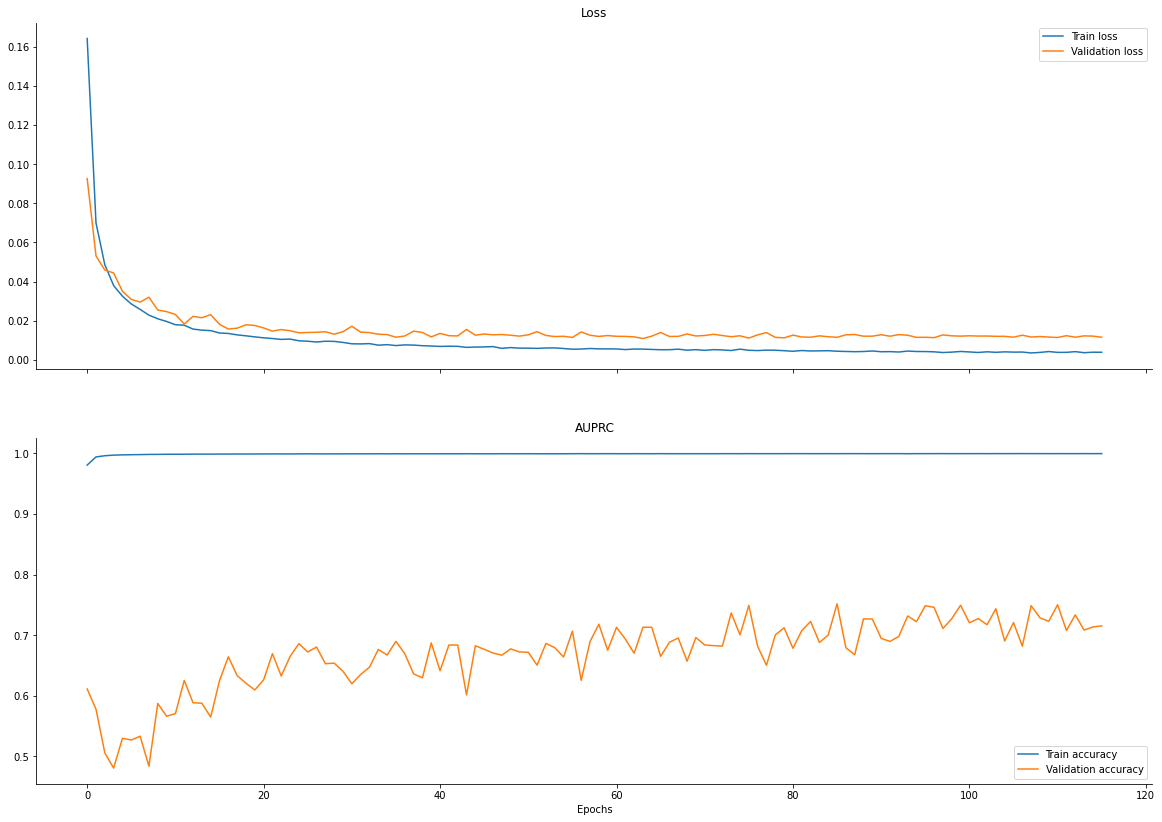

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['auprc'], label='Train accuracy')
ax2.plot(history['val_auprc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('AUPRC')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [94]:
y_pred = model.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
TF_Model_AUPRC = auprc.result().numpy()
TF_Model_AUPRC

0.6529712

In [95]:
TF_Model_metrics = compute_metrics(y_test, y_pred)
print_metrics(TF_Model_metrics)

Fraudulent Transactions Detected (True Positives): 78
Fraudulent Transactions Missed (False Negatives): 20
Legitimate Transactions Incorrectly Detected (False Positives): 76
Legitimate Transactions Detected (True Negatives): 56788


In [96]:
print('RF_AUPRC: ' + str(RF_AUPRC))
print('XGB_AUPRC: ' + str(XGB_AUPRC))
print('TF_Model_AUPRC: ' + str(TF_Model_AUPRC))

RF_AUPRC: 0.7073558
XGB_AUPRC: 0.041236956
TF_Model_AUPRC: 0.6529712


In [97]:
print('Random Forest ********************')
print_metrics(RF_metrics)
print('XGBoost **************************')
print_metrics(XGB_metrics)
print('TensorFlow DNN Model ************')
print_metrics(TF_Model_metrics)

Random Forest ********************
Fraudulent Transactions Detected (True Positives): 78
Fraudulent Transactions Missed (False Negatives): 20
Legitimate Transactions Incorrectly Detected (False Positives): 10
Legitimate Transactions Detected (True Negatives): 56854
XGBoost **************************
Fraudulent Transactions Detected (True Positives): 88
Fraudulent Transactions Missed (False Negatives): 10
Legitimate Transactions Incorrectly Detected (False Positives): 1855
Legitimate Transactions Detected (True Negatives): 55009
TensorFlow DNN Model ************
Fraudulent Transactions Detected (True Positives): 78
Fraudulent Transactions Missed (False Negatives): 20
Legitimate Transactions Incorrectly Detected (False Positives): 76
Legitimate Transactions Detected (True Negatives): 56788


In [98]:
tp_df['Model'] = models
results = [RF_metrics[0], XGB_metrics[0], TF_Model_metrics[0]]
tp_df['ADASYN'] = results
fn_df['Model'] = models
results = [RF_metrics[1], XGB_metrics[1], TF_Model_metrics[1]]
fn_df['ADASYN'] = results
fp_df['Model'] = models
results = [RF_metrics[2], XGB_metrics[2], TF_Model_metrics[2]]
fp_df['ADASYN'] = results
tn_df['Model'] = models
results = [RF_metrics[3], XGB_metrics[3], TF_Model_metrics[3]]
tn_df['ADASYN'] = results

In [99]:
results = [RF_AUPRC, XGB_AUPRC, TF_Model_AUPRC]
auprc_df['Oversampling ADASYN'] = results

# Combo (SMOTEENN)
 over-sampling using SMOTE (Synthetic Minority Over-sampling Technique) and cleaning using ENN (EditedNearestNeighbours) 

In [100]:
y_train = train_df['Class'].values
x_train = train_df.drop(['Class'], axis='columns')
x_train = x_train.values

In [101]:
%%time 
neg, pos = bincount(y_train)
print('Original balance: ' + str(neg) + ' non-fraud, ' + str(pos) + ' fraud')

from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=seed)
x_train, y_train = smote_enn.fit_resample(x_train, y_train)

neg, pos = bincount(y_train)
print('New balance: ' + str(neg) + ' non-fraud, ' + str(pos) + ' fraud')


Original balance: 181961 non-fraud, 315 fraud
New balance: 181644 non-fraud, 181961 fraud
CPU times: user 6min 8s, sys: 0 ns, total: 6min 8s
Wall time: 6min 8s


In [102]:
classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=seed)
classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=51, verbose=0,
                       warm_start=False)

In [103]:
y_pred = classifier.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
RF_AUPRC = auprc.result().numpy()
RF_AUPRC

0.658314

In [104]:
RF_metrics = compute_metrics(y_test, y_pred)
print_metrics(RF_metrics)

Fraudulent Transactions Detected (True Positives): 79
Fraudulent Transactions Missed (False Negatives): 19
Legitimate Transactions Incorrectly Detected (False Positives): 18
Legitimate Transactions Detected (True Negatives): 56846


In [105]:
%%time
xgbc = XGBClassifier(objective='binary:logistic', seed=seed)
xgbc.fit(x_train, y_train)

CPU times: user 1min 19s, sys: 0 ns, total: 1min 19s
Wall time: 1min 19s


In [106]:
y_pred = xgbc.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
XGB_AUPRC = auprc.result().numpy()
XGB_AUPRC

0.09770891

In [107]:
XGB_metrics = compute_metrics(y_test, y_pred)
print_metrics(XGB_metrics)

Fraudulent Transactions Detected (True Positives): 86
Fraudulent Transactions Missed (False Negatives): 12
Legitimate Transactions Incorrectly Detected (False Positives): 693
Legitimate Transactions Detected (True Negatives): 56171


In [108]:
model = create_model()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 96)                2976      
_________________________________________________________________
batch_normalization (BatchNo (None, 96)                384       
_________________________________________________________________
elu (ELU)                    (None, 96)                0         
_________________________________________________________________
dropout (Dropout)            (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96)               

In [109]:
checkpoint_filepath = 'model.h5'
mc = ModelCheckpoint(checkpoint_filepath, verbose=0, save_weights_only=True, 
                     monitor='val_auprc', mode='max', save_best_only=True)

es = EarlyStopping(monitor='val_auprc', patience=30, verbose=1, mode='max')
history = model.fit(x_train, y_train, epochs=200, verbose=2, callbacks=[es, mc], 
                    validation_data=(x_val, y_val), batch_size=BATCH_SIZE)

Epoch 1/200
1421/1421 - 8s - loss: 0.1298 - auroc: 0.9892 - auprc: 0.9903 - val_loss: 0.0782 - val_auroc: 0.9913 - val_auprc: 0.8049
Epoch 2/200
1421/1421 - 8s - loss: 0.0745 - auroc: 0.9966 - auprc: 0.9965 - val_loss: 0.0469 - val_auroc: 0.9882 - val_auprc: 0.7928
Epoch 3/200
1421/1421 - 8s - loss: 0.0529 - auroc: 0.9981 - auprc: 0.9978 - val_loss: 0.0392 - val_auroc: 0.9871 - val_auprc: 0.7714
Epoch 4/200
1421/1421 - 8s - loss: 0.0419 - auroc: 0.9987 - auprc: 0.9984 - val_loss: 0.0339 - val_auroc: 0.9716 - val_auprc: 0.7426
Epoch 5/200
1421/1421 - 8s - loss: 0.0357 - auroc: 0.9990 - auprc: 0.9987 - val_loss: 0.0291 - val_auroc: 0.9721 - val_auprc: 0.7128
Epoch 6/200
1421/1421 - 8s - loss: 0.0306 - auroc: 0.9992 - auprc: 0.9989 - val_loss: 0.0267 - val_auroc: 0.9722 - val_auprc: 0.6911
Epoch 7/200
1421/1421 - 8s - loss: 0.0278 - auroc: 0.9993 - auprc: 0.9990 - val_loss: 0.0263 - val_auroc: 0.9725 - val_auprc: 0.7079
Epoch 8/200
1421/1421 - 8s - loss: 0.0253 - auroc: 0.9993 - auprc: 0.

In [110]:
model.load_weights(checkpoint_filepath)
model.evaluate(x_test, y_test)

1781/1781 [==============================] - 5s 3ms/step - loss: 0.0798 - auroc: 0.9640 - auprc: 0.7505


[0.07979761809110641, 0.9639756679534912, 0.7505356669425964]

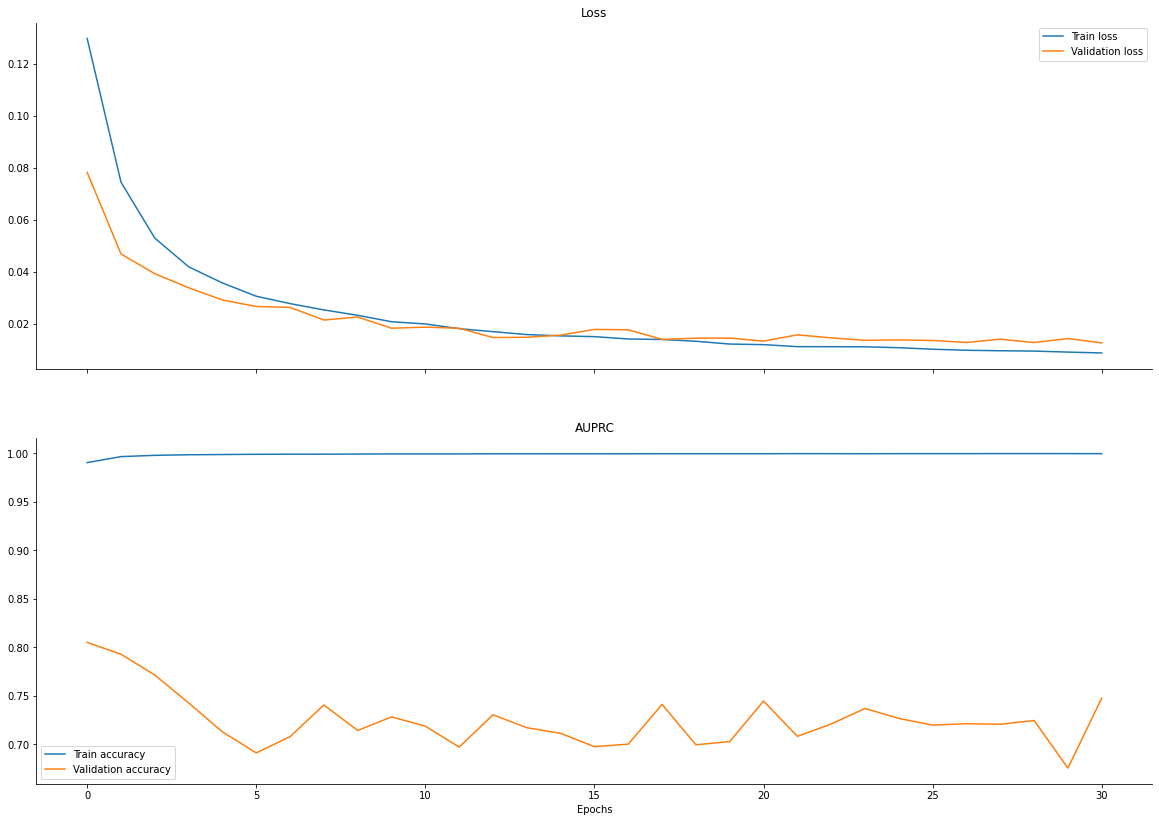

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['auprc'], label='Train accuracy')
ax2.plot(history['val_auprc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('AUPRC')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [112]:
y_pred = model.predict(x_test)
auprc = tf.keras.metrics.AUC(curve='PR')
auprc.update_state(y_test, y_pred)
TF_Model_AUPRC = auprc.result().numpy()
TF_Model_AUPRC

0.75053567

In [113]:
TF_Model_metrics = compute_metrics(y_test, y_pred)
print_metrics(TF_Model_metrics)

Fraudulent Transactions Detected (True Positives): 88
Fraudulent Transactions Missed (False Negatives): 10
Legitimate Transactions Incorrectly Detected (False Positives): 1682
Legitimate Transactions Detected (True Negatives): 55182


In [114]:
print('RF_AUPRC: ' + str(RF_AUPRC))
print('XGB_AUPRC: ' + str(XGB_AUPRC))
print('TF_Model_AUPRC: ' + str(TF_Model_AUPRC))

RF_AUPRC: 0.658314
XGB_AUPRC: 0.09770891
TF_Model_AUPRC: 0.75053567


In [115]:
print('Random Forest ********************')
print_metrics(RF_metrics)
print('XGBoost **************************')
print_metrics(XGB_metrics)
print('TensorFlow DNN Model ************')
print_metrics(TF_Model_metrics)

Random Forest ********************
Fraudulent Transactions Detected (True Positives): 79
Fraudulent Transactions Missed (False Negatives): 19
Legitimate Transactions Incorrectly Detected (False Positives): 18
Legitimate Transactions Detected (True Negatives): 56846
XGBoost **************************
Fraudulent Transactions Detected (True Positives): 86
Fraudulent Transactions Missed (False Negatives): 12
Legitimate Transactions Incorrectly Detected (False Positives): 693
Legitimate Transactions Detected (True Negatives): 56171
TensorFlow DNN Model ************
Fraudulent Transactions Detected (True Positives): 88
Fraudulent Transactions Missed (False Negatives): 10
Legitimate Transactions Incorrectly Detected (False Positives): 1682
Legitimate Transactions Detected (True Negatives): 55182


In [116]:
tp_df['Model'] = models
results = [RF_metrics[0], XGB_metrics[0], TF_Model_metrics[0]]
tp_df['SMOTEENN'] = results
fn_df['Model'] = models
results = [RF_metrics[1], XGB_metrics[1], TF_Model_metrics[1]]
fn_df['SMOTEENN'] = results
fp_df['Model'] = models
results = [RF_metrics[2], XGB_metrics[2], TF_Model_metrics[2]]
fp_df['SMOTEENN'] = results
tn_df['Model'] = models
results = [RF_metrics[3], XGB_metrics[3], TF_Model_metrics[3]]
tn_df['SMOTEENN'] = results

In [117]:
results = [RF_AUPRC, XGB_AUPRC, TF_Model_AUPRC]
auprc_df['Combo (SMOTEENN)'] = results

# Results Summary

Best resulting AUPRC was our baseline DNN model. However, the best Recall was when undersampling at the expense of Precision.



In [118]:
neg, pos = bincount(y_test)
print(str(neg) + ' non-fraud, ' + str(pos) + ' fraud')

56864 non-fraud, 98 fraud


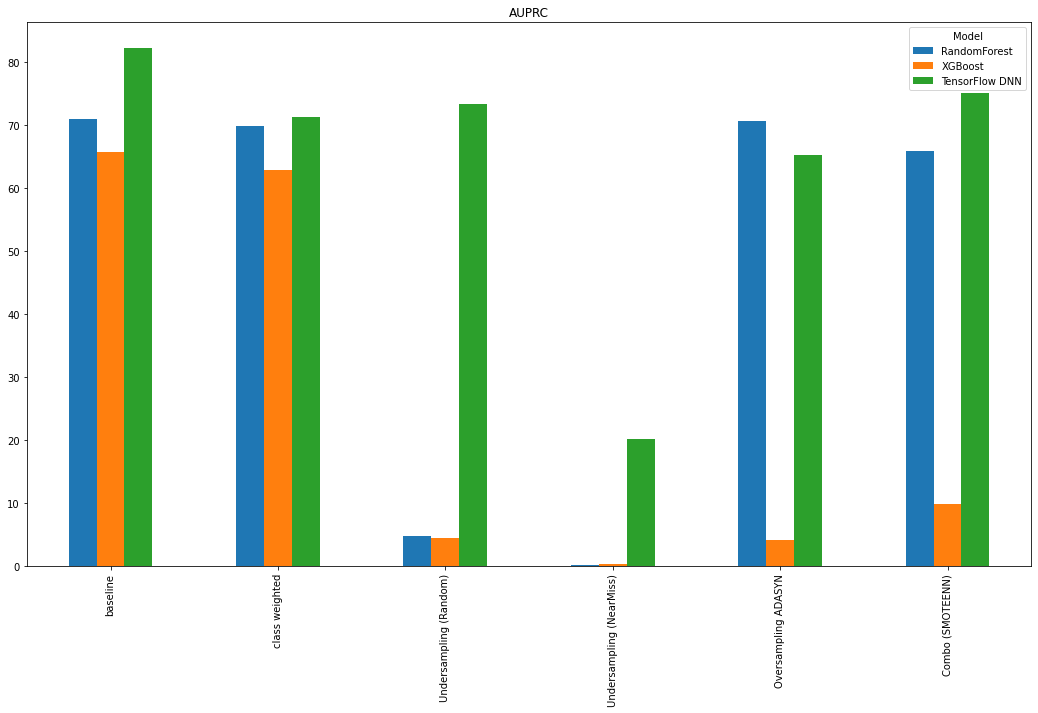

In [119]:
a = auprc_df.copy(deep=True)
a.index = a.Model
a.drop(['Model'], axis='columns', inplace=True)
a = a.T
a['RandomForest'] = a['RandomForest']*100
a['XGBoost'] = a['XGBoost']*100
a['TensorFlow DNN'] = a['TensorFlow DNN']*100
ax = a.plot.bar(rot=90, figsize=(18, 10), title='AUPRC')

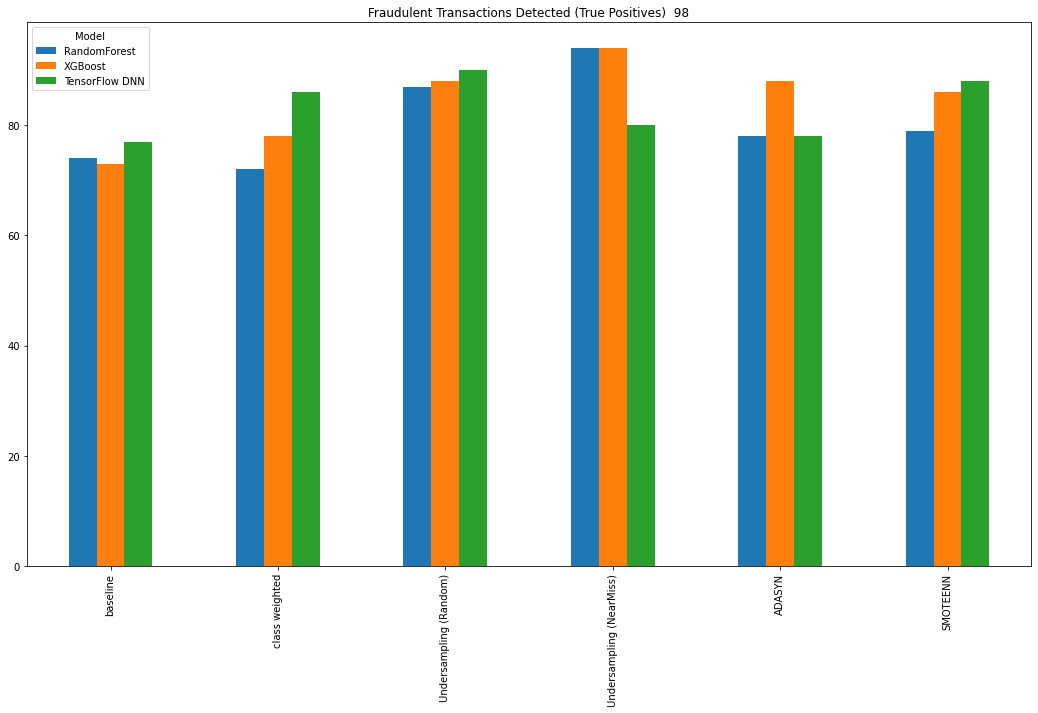

In [120]:
a = tp_df.copy(deep=True)
a.index = a.Model
a.drop(['Model'], axis='columns', inplace=True)
a = a.T
a['RandomForest'] = a['RandomForest']
a['XGBoost'] = a['XGBoost']
a['TensorFlow DNN'] = a['TensorFlow DNN']
ax = a.plot.bar(rot=90, figsize=(18, 10), title='Fraudulent Transactions Detected (True Positives)  98')

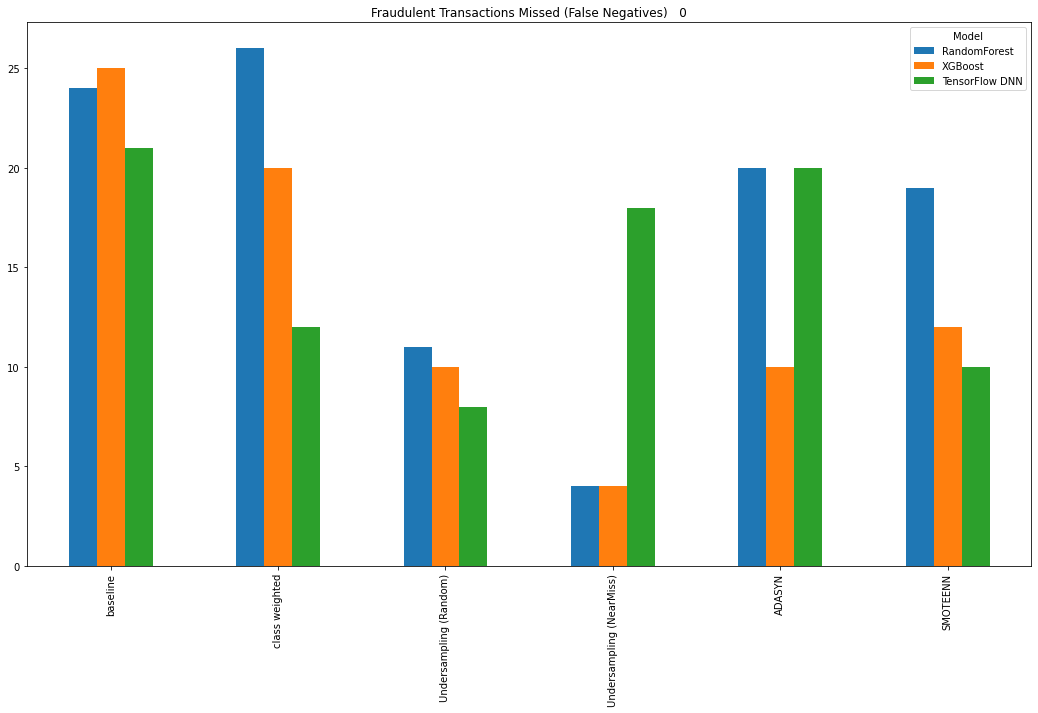

In [121]:
a = fn_df.copy(deep=True)
a.index = a.Model
a.drop(['Model'], axis='columns', inplace=True)
a = a.T
a['RandomForest'] = a['RandomForest']
a['XGBoost'] = a['XGBoost']
a['TensorFlow DNN'] = a['TensorFlow DNN']
ax = a.plot.bar(rot=90, figsize=(18, 10), title='Fraudulent Transactions Missed (False Negatives)   0')

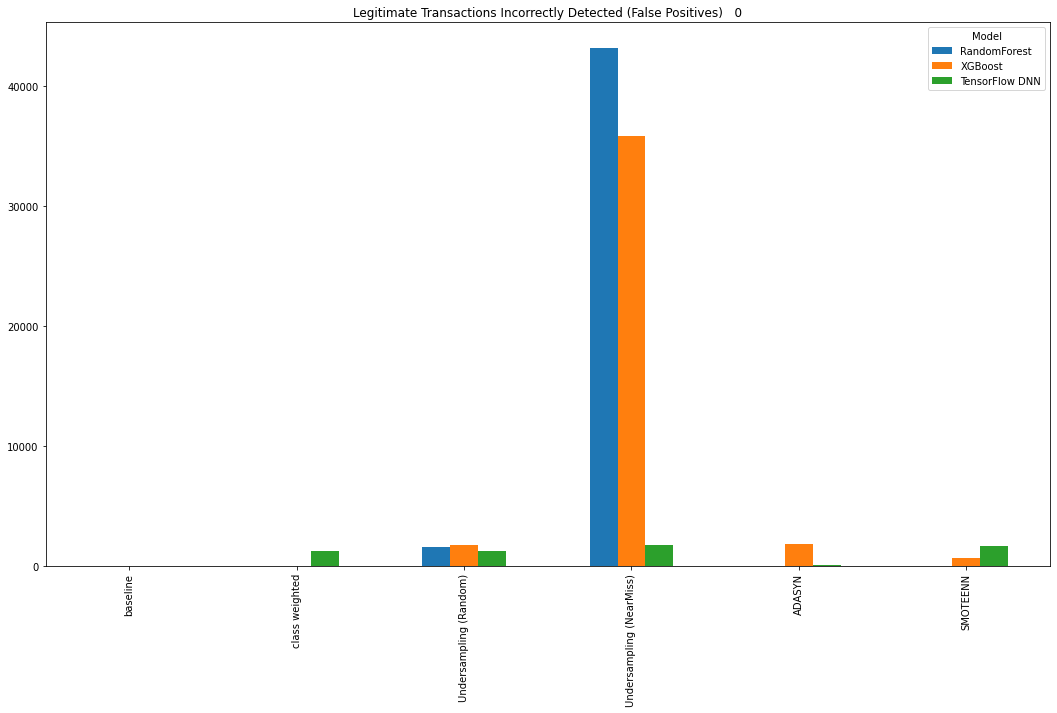

In [122]:
a = fp_df.copy(deep=True)
a.index = a.Model
a.drop(['Model'], axis='columns', inplace=True)
a = a.T
a['RandomForest'] = a['RandomForest']
a['XGBoost'] = a['XGBoost']
a['TensorFlow DNN'] = a['TensorFlow DNN']
ax = a.plot.bar(rot=90, figsize=(18, 10), title='Legitimate Transactions Incorrectly Detected (False Positives)   0')

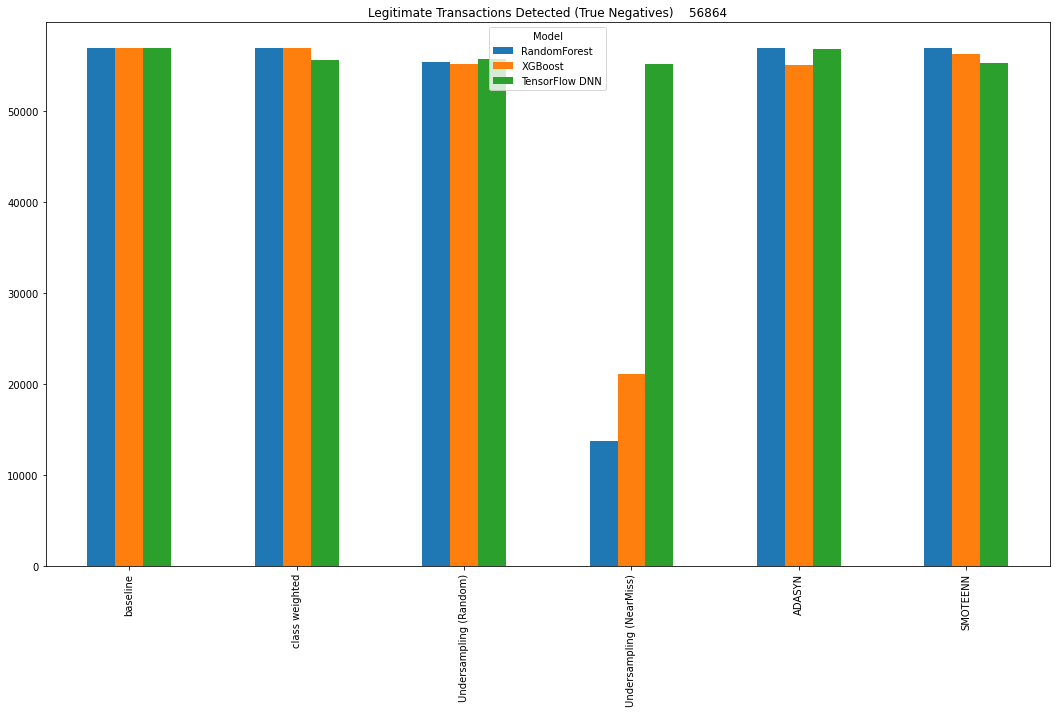

In [123]:
a = tn_df.copy(deep=True)
a.index = a.Model
a.drop(['Model'], axis='columns', inplace=True)
a = a.T
a['RandomForest'] = a['RandomForest']
a['XGBoost'] = a['XGBoost']
a['TensorFlow DNN'] = a['TensorFlow DNN']
ax = a.plot.bar(rot=90, figsize=(18, 10), title='Legitimate Transactions Detected (True Negatives)    56864')